# Emotional index using  cvx EDA

### RESEARCH ARTICLE

#### "cvxEDA: A Convex Optimization Approach to Electrodermal Activity Processing"

Publisher: IEEE

Alberto Greco;


El software no viene con una GUI. 

Suponiendo que 'y' es un vector con la señal EDA registrada muestreada a 25 Hz, 

yn = puntuación z(y)

EDA: electrodermal activity 

Fs = 25, señal EDA registrada muestreada

cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,

           solver=None, options={'reltol':1e-9}):
           
* y: señal EDA observada (recomendamos normalizarla: y = zscore(y))

* delta: intervalo de muestreo (en segundos) de y

* tau0: constante de tiempo lenta de la función Bateman
* tau1: constante de tiempo rápida de la función Bateman
* delta_knot: tiempo entre nudos de la función tónica spline
* alfa: penalización por el controlador SMNA disperso
* gamma: penalización por los coeficientes spline tónicos
* solver: se utilizará el solucionador QP disperso, consulte cvxopt.solvers.qp
* opciones: opciones del solucionador, consulte:

$$ [r, p, t, l, d, e, obj] = cvxEDA(yn, 1/Fs)$$

* r: componente fásico,  is the shape of a single phasic response (under assumptions A2 and A3)
* p: controlador SMNA disperso del componente fásico
* t: componente tónico (esta es la curva suavizada)
* l: coeficientes de spline tónica
* d: compensación y pendiente del término de deriva lineal
* e: residuos del modelo
* obj: valor de la función objetivo que se minimiza (ecuación 15 del artículo)

Link del artículo:
    https://ieeexplore.ieee.org/document/7229284

In [2]:
pip install cvxopt

Note: you may need to restart the kernel to use updated packages.


In [1]:
#import cvxEDA
import pylab as pl

import numpy as np
import cvxopt as cv
import cvxopt.solvers

import pandas as pd
pd.options.display.max_rows = 60 #None #60
pd.options.display.max_columns = 60 # None #70
import numpy as np
import matplotlib.pyplot as plt

In [2]:
y = np.random.rand(10)
y

array([0.71453892, 0.55849392, 0.37103672, 0.72064796, 0.4019998 ,
       0.71604348, 0.60061427, 0.3010067 , 0.6969202 , 0.76229402])

### DATOS DE  CONTROL (MD)

In [3]:
# read csv
df_datos1 = pd.read_csv('MD_control.csv')
df_datos1

,Hora,B: BVP,E: Skin Cond,G: Abd Resp
0,0.000488,0.000,10.389,35.289
1,0.000977,0.000,10.389,35.289
2,0.001465,0.000,10.389,35.289
3,0.001953,0.000,10.389,35.289
4,0.002441,0.001,10.389,35.289
...,...,...,...,...
535675,261.560547,35.898,9.430,34.796
535676,261.561035,35.898,9.430,34.796
535677,261.561523,35.898,9.430,34.796
535678,261.562012,35.897,9.430,34.796


In [4]:
v1 = df_datos1["E: Skin Cond"].to_numpy()
#v1
t1 = df_datos1["Hora"].to_numpy()
#t1

In [5]:
t1

array([4.88281250e-04, 9.76562500e-04, 1.46484375e-03, ...,
       2.61561523e+02, 2.61562012e+02, 2.61562500e+02])

## tomando el 1% de los datos

In [6]:
# GENERACION DE UN VECTOR CON EL 1% DE LOS DATOS PARA LA CONDUCTANCIA DE LA PIEL

n_vector1 = []

for i in range (0,535679,100):
    x = df_datos1.iloc[i,2]
    n_vector1.append(x)
print(n_vector1)

[10.389, 10.386, 10.377, 10.365, 10.349, 10.332, 10.313, 10.293, 10.272, 10.251, 10.229, 10.209, 10.187, 10.167, 10.146, 10.127, 10.108, 10.09, 10.072, 10.056, 10.04, 10.025, 10.01, 9.997, 9.983, 9.972, 9.96, 9.95, 9.94, 9.931, 9.922, 9.914, 9.906, 9.899, 9.892, 9.886, 9.88, 9.875, 9.871, 9.867, 9.864, 9.862, 9.862, 9.863, 9.866, 9.87, 9.877, 9.885, 9.896, 9.908, 9.923, 9.939, 9.957, 9.975, 9.995, 10.013, 10.033, 10.05, 10.068, 10.084, 10.099, 10.112, 10.123, 10.131, 10.138, 10.142, 10.145, 10.144, 10.141, 10.136, 10.129, 10.122, 10.113, 10.104, 10.094, 10.083, 10.071, 10.059, 10.044, 10.031, 10.015, 10.001, 9.986, 9.973, 9.959, 9.945, 9.931, 9.917, 9.903, 9.89, 9.877, 9.866, 9.854, 9.843, 9.832, 9.822, 9.812, 9.802, 9.793, 9.786, 9.779, 9.773, 9.767, 9.762, 9.758, 9.755, 9.752, 9.752, 9.753, 9.755, 9.759, 9.765, 9.773, 9.781, 9.792, 9.803, 9.817, 9.831, 9.846, 9.861, 9.877, 9.893, 9.91, 9.925, 9.942, 9.958, 9.978, 9.998, 10.024, 10.052, 10.085, 10.119, 10.158, 10.196, 10.239, 10.28, 1

In [7]:
# GENERACION DE UN VECTOR CON EL 1% DE LOS DATOS PARA EL TIEMPO

n_vtime = []

for i in range (0,535679,100):
    x = df_datos1.iloc[i,0]
    n_vtime.append(x)
print(n_vtime)

[0.00048828125, 0.04931640625, 0.09814453125, 0.14697265625, 0.19580078125, 0.24462890625, 0.29345703125, 0.34228515625, 0.39111328125, 0.43994140625, 0.48876953125, 0.53759765625, 0.58642578125, 0.63525390625, 0.68408203125, 0.73291015625, 0.78173828125, 0.83056640625, 0.87939453125, 0.92822265625, 0.97705078125, 1.02587890625, 1.07470703125, 1.12353515625, 1.17236328125, 1.22119140625, 1.27001953125, 1.31884765625, 1.36767578125, 1.41650390625, 1.46533203125, 1.51416015625, 1.56298828125, 1.61181640625, 1.66064453125, 1.70947265625, 1.75830078125, 1.80712890625, 1.85595703125, 1.90478515625, 1.95361328125, 2.00244140625, 2.05126953125, 2.10009765625, 2.14892578125, 2.19775390625, 2.24658203125, 2.29541015625, 2.34423828125, 2.39306640625, 2.44189453125, 2.49072265625, 2.53955078125, 2.58837890625, 2.63720703125, 2.68603515625, 2.73486328125, 2.78369140625, 2.83251953125, 2.88134765625, 2.93017578125, 2.97900390625, 3.02783203125, 3.07666015625, 3.12548828125, 3.17431640625, 3.2231445

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


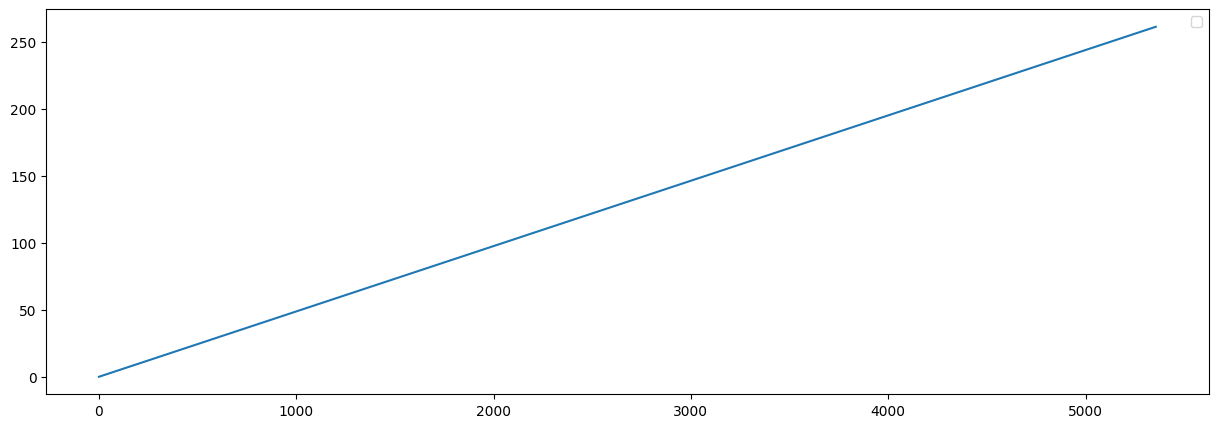

In [43]:
# el avance del tiempo no es lineal f(x)=x,  por lo que no puedo sustituirlo por un simple contador
fig,A = plt.subplots(1,1,figsize=(15,5))
A.plot(n_vtime)

plt.legend()
plt.show()

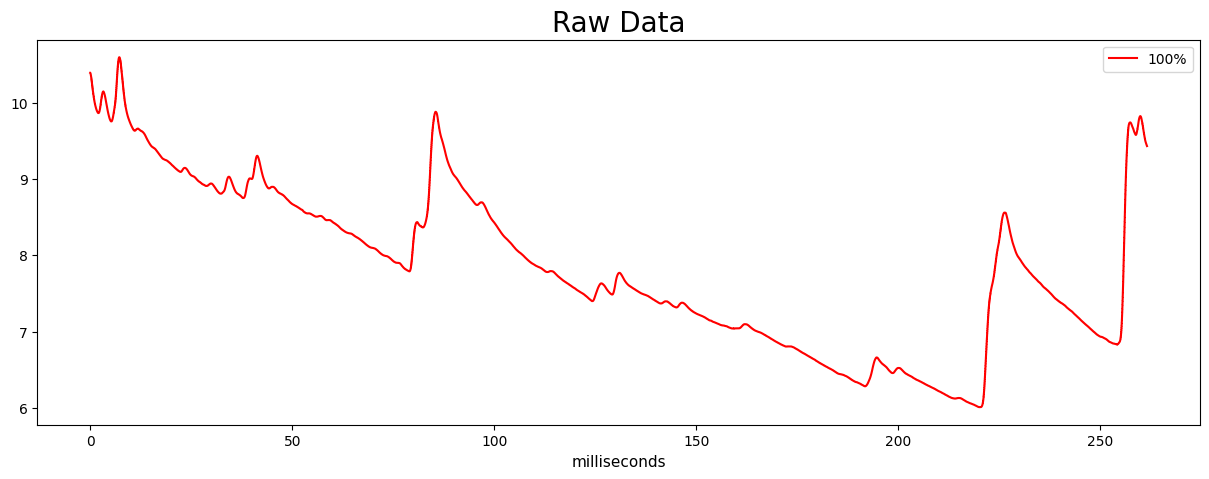

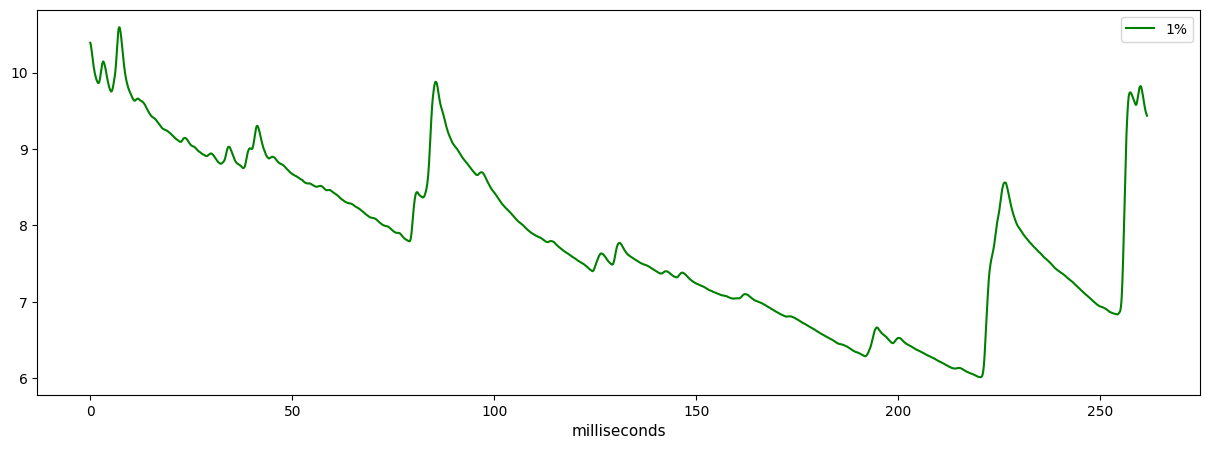

In [53]:
# COMPARACION DEL 100% VS EL 1%

fig,V = plt.subplots(1,1,figsize=(15,5))
V.plot(t1,v1,color = 'red', label='100%')
V.set_title('Raw Data',fontsize=20)
plt.xlabel('milliseconds',fontsize=11)
plt.legend()
fig,Q = plt.subplots(1,1,figsize=(15,5))
Q.plot(n_vtime,n_vector1,color = 'green', label='1%')
#Q.set_title('Raw Data',fontsize=20)
plt.xlabel('milliseconds',fontsize=11)

plt.legend()
plt.show()

In [ ]:
### FALTA PROCESAR ESTOS DATOS

In [8]:
# NORMALIZACION DEL VECTOR
import scipy 
from scipy import stats
y = stats.zscore(v1) # y ya está normalizado
Fs = 25;
print(y)

[2.36966345 2.36966345 2.36966345 ... 1.47268952 1.47268952 1.47268952]


In [9]:
import numpy as np
import cvxopt as cv
import cvxopt.solvers

def cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9}):
    """CVXEDA Convex optimization approach to electrodermal activity processing
    This function implements the cvxEDA algorithm described in "cvxEDA: a
    Convex Optimization Approach to Electrodermal Activity Processing"
    (http://dx.doi.org/10.1109/TBME.2015.2474131, also available from the
    authors' homepages).
    Arguments:
       y: observed EDA signal (we recommend normalizing it: y = zscore(y))
       delta: sampling interval (in seconds) of y
       tau0: slow time constant of the Bateman function
       tau1: fast time constant of the Bateman function
       delta_knot: time between knots of the tonic spline function
       alpha: penalization for the sparse SMNA driver
       gamma: penalization for the tonic spline coefficients
       solver: sparse QP solver to be used, see cvxopt.solvers.qp
       options: solver options, see:
                http://cvxopt.org/userguide/coneprog.html#algorithm-parameters
    Returns (see paper for details):
       r: phasic component
       p: sparse SMNA driver of phasic component
       t: tonic component
       l: coefficients of tonic spline
       d: offset and slope of the linear drift term
       e: model residuals
       obj: value of objective function being minimized (eq 15 of paper)
    """

    n = len(y)
    y = cv.matrix(y)

    # bateman ARMA model
    a1 = 1./min(tau1, tau0) # a1 > a0
    a0 = 1./max(tau1, tau0)
    ar = np.array([(a1*delta + 2.) * (a0*delta + 2.), 2.*a1*a0*delta**2 - 8.,
        (a1*delta - 2.) * (a0*delta - 2.)]) / ((a1 - a0) * delta**2)
    ma = np.array([1., 2., 1.])

    # matrices for ARMA model
    i = np.arange(2, n)
    A = cv.spmatrix(np.tile(ar, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))
    M = cv.spmatrix(np.tile(ma, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))

    # spline
    delta_knot_s = int(round(delta_knot / delta))
    spl = np.r_[np.arange(1.,delta_knot_s), np.arange(delta_knot_s, 0., -1.)] # order 1
    spl = np.convolve(spl, spl, 'full')
    spl /= max(spl)
    # matrix of spline regressors
    i = np.c_[np.arange(-(len(spl)//2), (len(spl)+1)//2)] + np.r_[np.arange(0, n, delta_knot_s)]
    nB = i.shape[1]
    j = np.tile(np.arange(nB), (len(spl),1))
    p = np.tile(spl, (nB,1)).T
    valid = (i >= 0) & (i < n)
    B = cv.spmatrix(p[valid], i[valid], j[valid])

    # trend
    C = cv.matrix(np.c_[np.ones(n), np.arange(1., n+1.)/n])
    nC = C.size[1]

    # Solve the problem:
    # .5*(M*q + B*l + C*d - y)^2 + alpha*sum(A,1)*p + .5*gamma*l'*l
    # s.t. A*q >= 0

    old_options = cv.solvers.options.copy()
    cv.solvers.options.clear()
    cv.solvers.options.update(options)
    if solver == 'conelp':
        # Use conelp
        z = lambda m,n: cv.spmatrix([],[],[],(m,n))
        G = cv.sparse([[-A,z(2,n),M,z(nB+2,n)],[z(n+2,nC),C,z(nB+2,nC)],
                    [z(n,1),-1,1,z(n+nB+2,1)],[z(2*n+2,1),-1,1,z(nB,1)],
                    [z(n+2,nB),B,z(2,nB),cv.spmatrix(1.0, range(nB), range(nB))]])
        h = cv.matrix([z(n,1),.5,.5,y,.5,.5,z(nB,1)])
        c = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T,z(nC,1),1,gamma,z(nB,1)])
        res = cv.solvers.conelp(c, G, h, dims={'l':n,'q':[n+2,nB+2],'s':[]})
        obj = res['primal objective']
    else:
        # Use qp
        Mt, Ct, Bt = M.T, C.T, B.T
        H = cv.sparse([[Mt*M, Ct*M, Bt*M], [Mt*C, Ct*C, Bt*C], 
                    [Mt*B, Ct*B, Bt*B+gamma*cv.spmatrix(1.0, range(nB), range(nB))]])
        f = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T - Mt*y,  -(Ct*y), -(Bt*y)])
        res = cv.solvers.qp(H, f, cv.spmatrix(-A.V, A.I, A.J, (n,len(f))),
                            cv.matrix(0., (n,1)), solver=solver)
        obj = res['primal objective'] + .5 * (y.T * y)
    cv.solvers.options.clear()
    cv.solvers.options.update(old_options)

    l = res['x'][-nB:]
    d = res['x'][n:n+nC]
    t = B*l + C*d
    q = res['x'][:n]
    p = A * q
    r = M * q
    e = y - r - t

    return (np.array(a).ravel() for a in (r, p, t, l, d, e, obj))


In [10]:
cvxEDA(y, 1./Fs)

     pcost       dcost       gap    pres   dres
 0: -2.6783e+05 -2.6735e+05  6e+05  8e+02  6e-02
 1: -2.6742e+05 -3.1920e+05  6e+04  7e+01  5e-03
 2: -2.6736e+05 -2.7433e+05  7e+03  8e+00  6e-04


KeyboardInterrupt: 

In [11]:
# y ya estaba normalizado, este cálculo no  es necesario
#yn = (y - y.mean()) / y.std() 
Fs = 25.

     pcost       dcost       gap    pres   dres
 0: -2.6783e+05 -2.6735e+05  6e+05  8e+02  6e-02
 1: -2.6742e+05 -3.1920e+05  6e+04  7e+01  5e-03
 2: -2.6736e+05 -2.7433e+05  7e+03  8e+00  6e-04
 3: -2.6737e+05 -2.6794e+05  6e+02  1e-01  9e-06
 4: -2.6775e+05 -2.6784e+05  9e+01  2e-02  1e-06
 5: -2.6779e+05 -2.6784e+05  5e+01  7e-03  5e-07
 6: -2.6782e+05 -2.6784e+05  2e+01  2e-03  2e-07
 7: -2.6783e+05 -2.6784e+05  8e+00  7e-04  5e-08
 8: -2.6784e+05 -2.6784e+05  2e+00  1e-04  1e-08
 9: -2.6784e+05 -2.6784e+05  3e-01  6e-06  4e-10
10: -2.6784e+05 -2.6784e+05  7e-02  9e-07  7e-11
11: -2.6784e+05 -2.6784e+05  4e-02  3e-07  2e-11
12: -2.6784e+05 -2.6784e+05  9e-03  6e-08  5e-12
13: -2.6784e+05 -2.6784e+05  7e-03  4e-08  3e-12
14: -2.6784e+05 -2.6784e+05  2e-03  8e-09  6e-13
15: -2.6784e+05 -2.6784e+05  2e-03  4e-09  3e-13
16: -2.6784e+05 -2.6784e+05  6e-04  1e-09  1e-13
17: -2.6784e+05 -2.6784e+05  4e-04  4e-10  5e-14
18: -2.6784e+05 -2.6784e+05  9e-05  7e-11  4e-14
Optimal solution foun

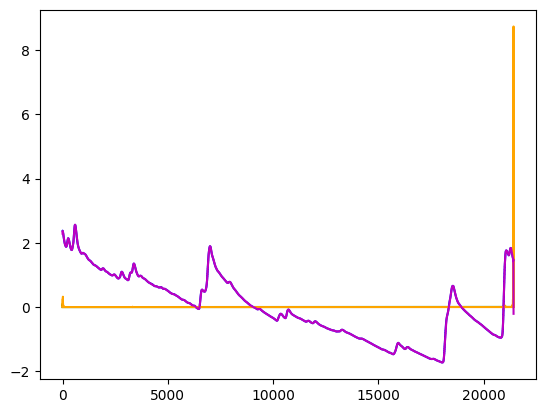

In [13]:
# con el 100% de los datos no funciona bien
#yn = (y - y.mean()) / y.std()
Fs = 25.
[r, p, t, l, d, e, obj] = cvxEDA(y, 1./Fs) # cvxEDA(yn, 1./Fs)

import pylab as pl
tm = pl.arange(1., len(y)+1.) / Fs
#pl.hold(True)
pl.plot(tm, y, color= 'blue')
pl.plot(tm, r, color= 'green')
pl.plot(tm, p, color= 'orange')
pl.plot(tm, t, color= 'm')
pl.show()


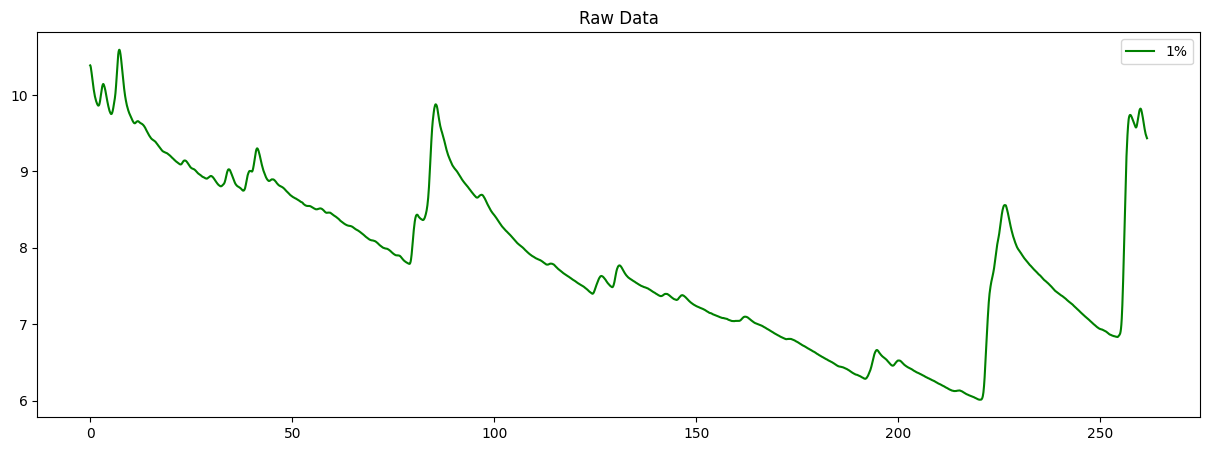

In [14]:
fig,V = plt.subplots(1,1,figsize=(15,5))
V.plot(n_vtime,n_vector1,color = 'green', label='1%')
V.set_title('Raw Data')
plt.legend()
plt.show()

In [16]:
n_zscore1 = stats.zscore(n_vector1)
print(n_zscore1)

[2.36911223 2.36630676 2.35789034 ... 1.49099886 1.48445275 1.47697149]


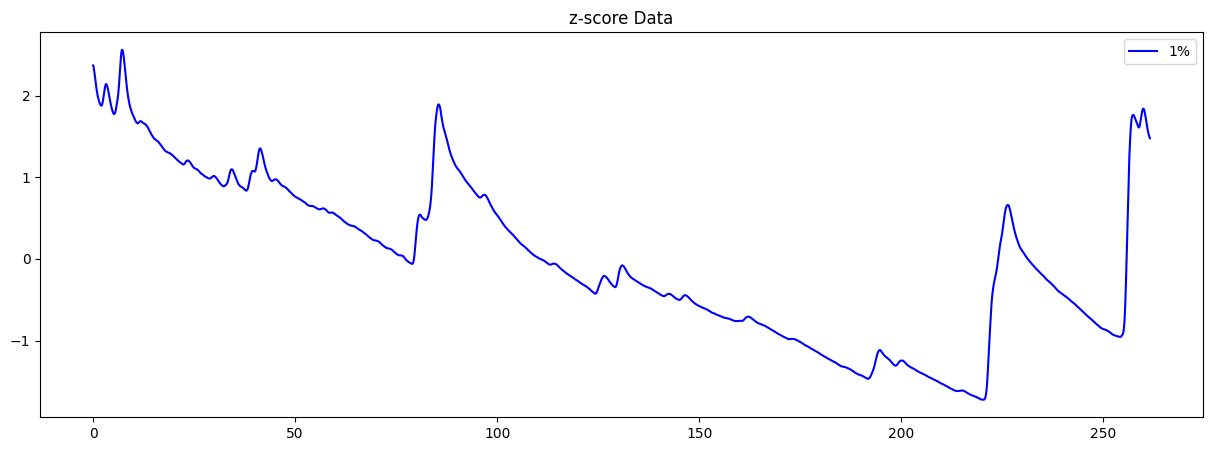

In [17]:
fig,W = plt.subplots(1,1,figsize=(15,5))
W.plot(n_vtime,n_zscore1,color = 'blue', label='1%')
W.set_title('z-score Data')
plt.legend()
plt.show()

In [18]:
tm =[]
for i in range(len(n_vtime)):
    tm.append(n_vtime[i]/Fs)
        
tm

# no sé que significa que tm salga así

[1.953125e-05,
 0.00197265625,
 0.00392578125,
 0.00587890625,
 0.00783203125,
 0.00978515625,
 0.01173828125,
 0.01369140625,
 0.01564453125,
 0.01759765625,
 0.01955078125,
 0.02150390625,
 0.02345703125,
 0.02541015625,
 0.02736328125,
 0.02931640625,
 0.03126953125,
 0.03322265625,
 0.03517578125,
 0.03712890625,
 0.03908203125,
 0.04103515625,
 0.04298828125,
 0.04494140625,
 0.04689453125,
 0.04884765625,
 0.05080078125,
 0.05275390625,
 0.05470703125,
 0.05666015625,
 0.05861328125,
 0.06056640625,
 0.06251953125,
 0.06447265625,
 0.06642578125,
 0.06837890625,
 0.07033203125,
 0.07228515625,
 0.07423828125,
 0.07619140625,
 0.07814453125,
 0.08009765625,
 0.08205078125,
 0.08400390625,
 0.08595703125,
 0.08791015625,
 0.08986328125,
 0.09181640625,
 0.09376953125,
 0.09572265625,
 0.09767578125,
 0.09962890625,
 0.10158203125,
 0.10353515625,
 0.10548828125,
 0.10744140625,
 0.10939453125,
 0.11134765625,
 0.11330078125,
 0.11525390625,
 0.11720703125,
 0.11916015625,
 0.121113

     pcost       dcost       gap    pres   dres
 0: -2.6161e+03 -2.5583e+03  1e+04  9e+01  4e+00
 1: -2.6461e+03 -4.3262e+03  2e+03  2e+01  9e-01
 2: -2.6660e+03 -3.1401e+03  5e+02  3e+00  2e-01
 3: -2.6688e+03 -2.7808e+03  1e+02  6e-01  3e-02
 4: -2.6703e+03 -2.6882e+03  2e+01  7e-02  3e-03
 5: -2.6742e+03 -2.6779e+03  4e+00  7e-04  3e-05
 6: -2.6766e+03 -2.6776e+03  1e+00  2e-04  7e-06
 7: -2.6770e+03 -2.6774e+03  4e-01  3e-05  1e-06
 8: -2.6772e+03 -2.6773e+03  9e-02  5e-06  2e-07
 9: -2.6772e+03 -2.6773e+03  5e-02  2e-06  7e-08
10: -2.6772e+03 -2.6772e+03  1e-02  4e-07  2e-08
11: -2.6772e+03 -2.6772e+03  8e-03  1e-07  6e-09
12: -2.6772e+03 -2.6772e+03  2e-03  3e-08  1e-09
13: -2.6772e+03 -2.6772e+03  2e-03  2e-08  8e-10
14: -2.6772e+03 -2.6772e+03  4e-04  3e-09  1e-10
15: -2.6772e+03 -2.6772e+03  2e-04  1e-09  6e-11
16: -2.6772e+03 -2.6772e+03  7e-05  3e-10  2e-11
17: -2.6772e+03 -2.6772e+03  5e-05  2e-10  9e-12
18: -2.6772e+03 -2.6772e+03  1e-05  4e-11  2e-12
19: -2.6772e+03 -2.67

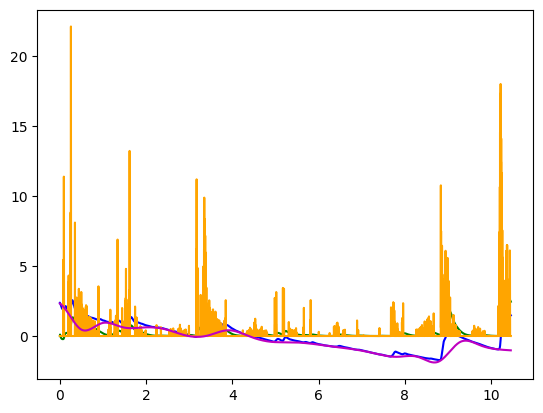

In [19]:
Fs = 25.
[r, p, t, l, d, e, obj] = cvxEDA(n_zscore1, 1./Fs)

import pylab as pl
#tm =  pl.arange(1., len(n_zscore1)+1.) / Fs
#pl.hold(True)
plt.plot(figsize=(15,5))
pl.plot(tm, n_zscore1, color= 'blue',  label=' raw zscore data')
pl.plot(tm, r, color= 'green',  label='phasic component')
pl.plot(tm, p, color= 'orange',  label='sparse SMNA driver of phasic component')
pl.plot(tm, t, color= 'm',  label=' tonic component')
pl.show()

In [20]:
print(len(tm))
print( )
print(tm)

5357

[1.953125e-05, 0.00197265625, 0.00392578125, 0.00587890625, 0.00783203125, 0.00978515625, 0.01173828125, 0.01369140625, 0.01564453125, 0.01759765625, 0.01955078125, 0.02150390625, 0.02345703125, 0.02541015625, 0.02736328125, 0.02931640625, 0.03126953125, 0.03322265625, 0.03517578125, 0.03712890625, 0.03908203125, 0.04103515625, 0.04298828125, 0.04494140625, 0.04689453125, 0.04884765625, 0.05080078125, 0.05275390625, 0.05470703125, 0.05666015625, 0.05861328125, 0.06056640625, 0.06251953125, 0.06447265625, 0.06642578125, 0.06837890625, 0.07033203125, 0.07228515625, 0.07423828125, 0.07619140625, 0.07814453125, 0.08009765625, 0.08205078125, 0.08400390625, 0.08595703125, 0.08791015625, 0.08986328125, 0.09181640625, 0.09376953125, 0.09572265625, 0.09767578125, 0.09962890625, 0.10158203125, 0.10353515625, 0.10548828125, 0.10744140625, 0.10939453125, 0.11134765625, 0.11330078125, 0.11525390625, 0.11720703125, 0.11916015625, 0.12111328125, 0.12306640625, 0.12501953125, 0.12697265625, 0.12

In [27]:
len(n_zscore1) # len(t) = 5357

5357

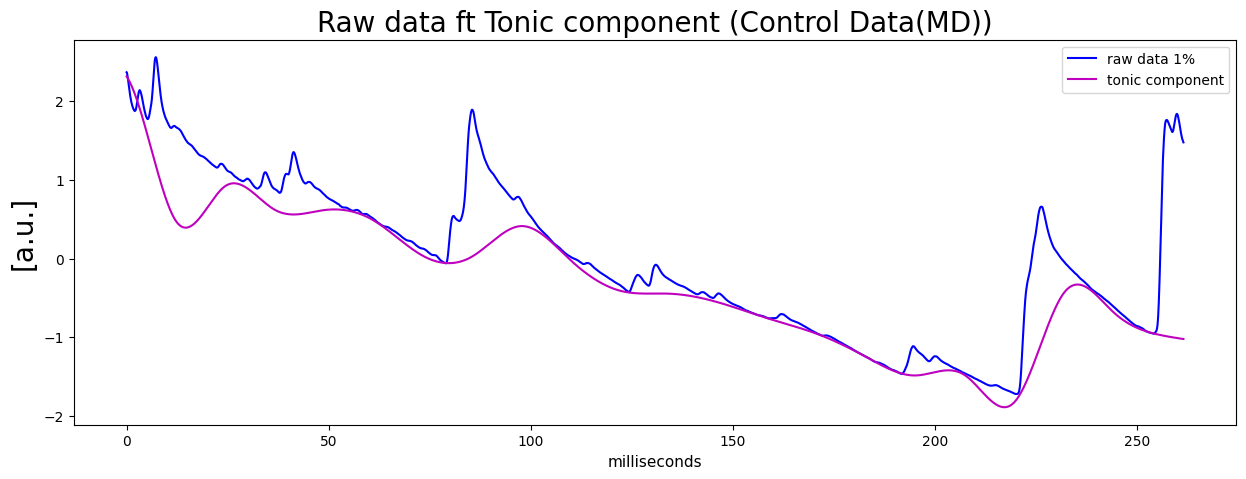

In [33]:
plt.figure(figsize=(15,5))
#plt.xlim(500,650000)
#plt.ylim(15,50)
plt.plot(n_vtime,n_zscore1,color = 'blue', label='raw data 1%')
plt.plot(n_vtime,t,color = 'm', label='tonic component')
plt.ylabel('[a.u.]',fontsize=20) #unidad adimensional normalizada de los datos del programa
plt.xlabel('milliseconds',fontsize=11)
plt.title('Raw data ft Tonic component (Control Data(MD))',fontsize=20)
plt.legend()
plt.show()

## Cálculo del index

## Emotional Index
1. To obtain the HR signal, employ the Pan-Tompkins algorithm.

2. Acquire the skin conductance using the constant voltage method (0.5 V).

3. Use LEDAlab software67 to obtain the tonic component of the skin conductance (i.e., skin conductance level (SCL)).

    a. Select "Continuous Decomposition Analysis" from the analysis menu.
    NOTE: It is recommended to optimize the analysis by clicking the "Optimize" button.
    
    b. Click on "Apply" to accept the analysis and have the decomposition plotted.
    
    
4. For the purpose of matching SCL and HR signals, refer to the circumplex model of affect plan [63,64], where the coordinates of a point in space are defined respectively by the HR (horizontal axis) to describe the valence and by the SCL (vertical axis) to describe the arousal phenomena.

5. To obtain a monodimensional variable, use the emotional state of a subject as described by the EI 10, defined by the formula:

$$ EI= 1 - β/π $$

NOTE: Here:

$\qquad \qquad  \qquad \qquad β = $

$$ \frac{3}{2} \pi + \pi - \theta \quad if \quad GSR_z \geqslant 0, \quad HR_z \leqslant 0, $$
$$ \frac{\pi}{2}  - \theta \quad otherwise $$ 

$HR$ and $GSR_z$ constitute the Ζ-score variables of HR and GSR, respectively, $ \theta $ is in radians, calculated as 

$$ arctang (HR_z,GSR_z)$$

Because the angle will vary between [−1, 1], the EI will vary between [−1, 1].

Bibliografía:

URL: https://www.jove.com/video/55872

DOI: doi:10.3791/55872


### Obtencíon de los datos HR_z

In [22]:
df_datos1['B: BVP'].min()

0.0

In [26]:
# GENERACION DE UN VECTOR CON EL 1% DE LOS DATOS PARA EL RITMO  CARDIACO

b1 = []

for i in range (0,535679,100):
    x = df_datos1.iloc[i,1]
    b1.append(x)
print(b1)

[0.0, 22.684, 41.425, 36.699, 38.018, 37.499, 37.665, 37.826, 37.856, 37.813, 37.788, 37.734, 37.705, 37.708, 37.756, 37.751, 37.74, 37.902, 38.426, 38.578, 38.376, 38.175, 38.022, 38.12, 38.154, 38.028, 37.796, 37.589, 37.448, 37.381, 37.351, 37.277, 37.32, 37.723, 37.96, 37.823, 37.632, 37.436, 37.44, 37.516, 37.473, 37.399, 37.321, 37.245, 37.192, 37.175, 37.1, 37.073, 37.351, 37.938, 37.989, 37.843, 37.651, 37.487, 37.629, 37.684, 37.585, 37.499, 37.43, 37.337, 37.323, 37.322, 37.205, 37.157, 37.383, 37.955, 37.816, 37.501, 37.203, 37.072, 37.174, 37.233, 37.155, 37.206, 37.355, 37.443, 37.428, 37.333, 37.189, 37.098, 37.198, 37.348, 37.278, 36.924, 36.326, 35.774, 35.642, 35.582, 35.091, 34.723, 34.677, 34.949, 35.396, 35.757, 36.228, 36.996, 37.392, 37.351, 37.255, 37.059, 37.241, 37.506, 37.665, 37.763, 37.894, 37.891, 37.933, 37.913, 38.14, 38.63, 38.655, 38.415, 38.194, 38.096, 38.277, 38.438, 38.386, 38.304, 38.235, 38.147, 38.125, 38.519, 38.903, 38.911, 38.761, 38.492, 38.3

In [106]:
len(b1)

5357

In [29]:
# NORMALIZACION DEL VECTOR
import scipy 
from scipy import stats
b = stats.zscore(b1) # y ya está normalizado
Fs = 25;
print(b)

[-31.87297615 -12.63465157   3.25961051 ...  -0.88929991  -1.1216796
  -1.30826183]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


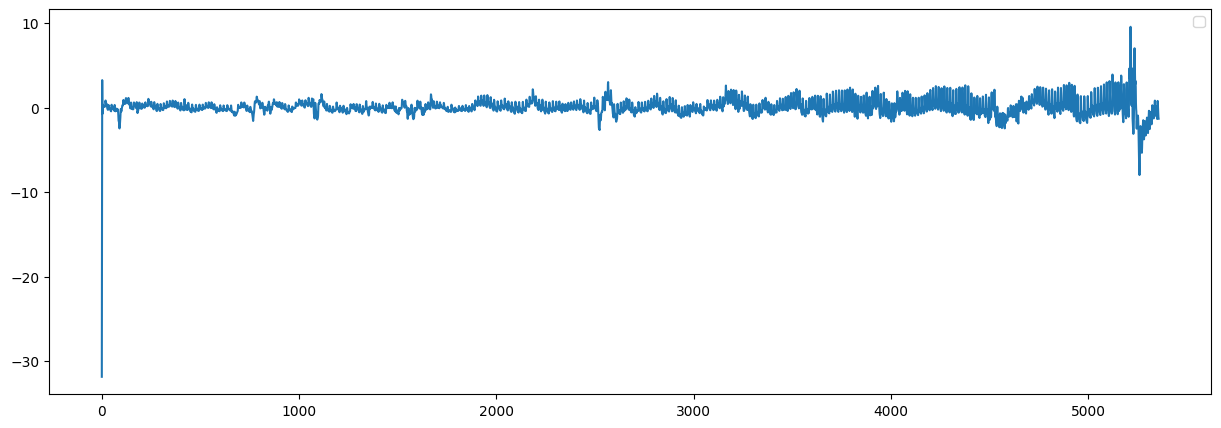

In [30]:
# el avance del tiempo no es lineal f(x)=x,  por lo que no puedo sustituirlo por un simple contador
fig,B = plt.subplots(1,1,figsize=(15,5))
B.plot(b)

plt.legend()
plt.show()

https://www.hindawi.com/journals/cmmm/2014/912981/

### Research Article | Open Access
Volume 2014 | Article ID 912981 | https://doi.org/10.1155/2014/912981
#### "Neurophysiological Tools to Investigate Consumer’s Gender Differences during the Observation of TV Commercials"
Giovanni Vecchiato

Emotional Index
The Emotional Index is defined by taking into account the GSR and HR signals. As far as the construction of such variable is concerned, we refer to effects plane [39] where the coordinates of a point in this space are defined by the HR (horizontal axis) and the GSR (vertical axis). Several studies have highlighted that these two autonomic parameters correlate with valence and arousal, respectively (see [40] for a review).

In order to have a monodimensional variable, we describe the emotional state of a subject by defining the following Emotional Index (EI):

$GSR_z$, $HR_z$  represent the Z-score variables of GSR and HR respectively; $\theta$ , in radians, is measured as . Therefore, the angle $ \beta$ is defined in order to obtain the EI varying between . According to (2) and (3) and the effect plane [39], negative ($HR_z$) and positive ($GSR_z$) values of the EI are related to negative and positive emotions, respectively, spanning the whole effect plane. In the following, we will refer to the Emotional Index as Emotion.

Such cerebral indices take into account that the strong involvement of frontal and prefrontal areas has been already experienced in previous studies performed with high resolution EEG, functional connectivity, and graph theory tools [41–47] as well as in higher cognitive tasks [48–50].


### RESEARCH ARTICLE

#### "Analysis of physiological and non-contact signals to evaluate the emotional component in consumer preferences"

Rita LaureantiID*, Riccardo Barbieri, Luca Cerina, Luca Mainardi

Department of Electronics, Information and Bioengineering (DEIB), Politecnico di Milano, Milan, Italy


The index is based on the circumplex model of affect plan [21], where the coordinates of a point in space are defined respectively by the heart rate (horizontal axis) to describe the valence
and by the SCL (vertical axis) to describe the arousal level. The EI put together the information of both indexes to obtain a monodimenisional variable varying from [-1, 1], where a higher EI value indicates a more positive emotion experienced by the participant [20].

In [36]:
# ESTE VECTOR ES GSR_z
print(len(t))
print('GSR_z: ',t,)

5357
GSR_z:  [ 2.31642133  2.31259118  2.30867503 ... -1.02311192 -1.02347373
 -1.02383471]


In [37]:
# ESTE VECTOR ES HR_z
print(len(b))
print('HR_z: ',b,)

5357
HR_z:  [-31.87297615 -12.63465157   3.25961051 ...  -0.88929991  -1.1216796
  -1.30826183]


In [61]:

# GENERACION DE UN VECTOR theta
theta = []
for i in range (0,5357):
    r = t[i]/b[i]   # t = GSR_z   &  HR_z = b
    x = math.atan(r) #resultado en radianes
    theta.append(x)
#print(theta)

# GENERACION DE UN VECTOR EMOTIONAL INDEX
beta = np.zeros (5357)
EI = np.zeros (5357)
for i in range (0,5357):
    if t[i] >= 0 and b[i] <= 0:
        beta[i] = (2/3)*math.pi + math.pi - theta[i]
    else:
        beta[i] = math.pi/2 - theta[i]

    EI[i] = 1- beta[i]/math.pi

print(EI)


[-0.68975976 -0.72429085  0.69615938 ...  0.77223599  0.73543783
  0.71136908]


In [75]:
print(EI)

[-0.68975976 -0.72429085  0.69615938 ...  0.77223599  0.73543783
  0.71136908]


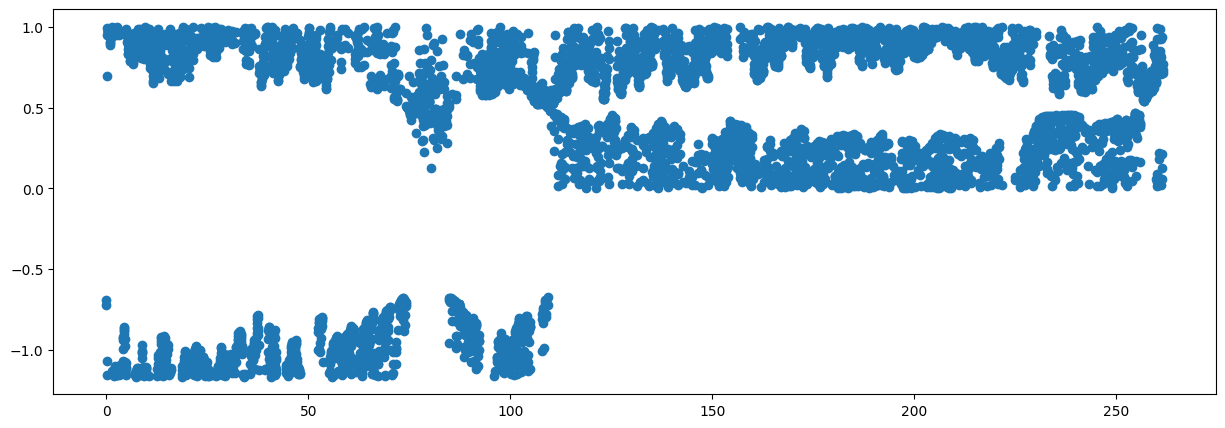

In [73]:
plt.figure(figsize=(15,5))
#plt.plot(n_vtime,EI,color = 'blue', label='Emotional index')
plt.scatter(n_vtime,EI) #,label='Emotional index')
#plt.ylabel('',fontsize=20) #unidad adimensional normalizada de los datos del programa
#plt.xlabel('',fontsize=11)
#plt.title('Emotional index over time in the control test (MD data)',fontsize=20)
#plt.legend()
plt.show()

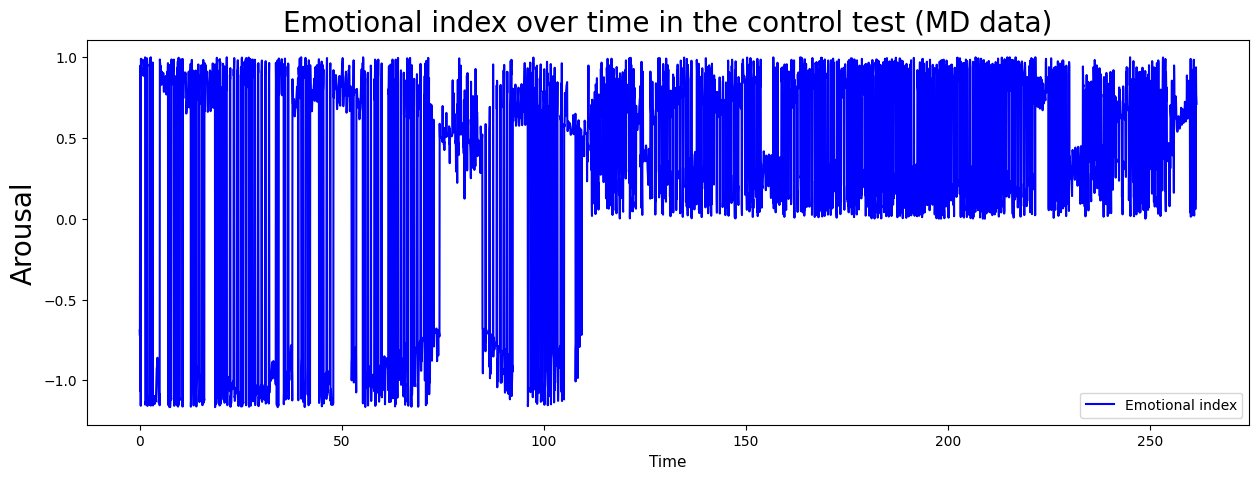

In [76]:
plt.figure(figsize=(15,5))
plt.plot(n_vtime,EI,color = 'blue', label='Emotional index')
plt.ylabel('Arousal',fontsize=20) #unidad adimensional normalizada de los datos del programa
plt.xlabel('Time',fontsize=11)
plt.title('Emotional index over time in the control test (MD data)',fontsize=20)
plt.legend()
plt.show()

# PROCESAMIENTO DE LOS DATOS DE  AMBIGÜEDAD (MD)

In [108]:
# read csv
df_datos2 = pd.read_csv('MD_ambiguedad.csv')
df_datos2

,Hora,B: BVP,E: Skin Cond,G: Abd Resp
0,0.000488,0.000,9.271,35.689
1,0.000977,0.000,9.271,35.689
2,0.001465,0.000,9.271,35.689
3,0.001953,0.000,9.271,35.689
4,0.002441,0.001,9.271,35.689
...,...,...,...,...
655739,320.185547,38.032,12.397,36.508
655740,320.186035,38.040,12.397,36.508
655741,320.186523,38.048,12.397,36.508
655742,320.187012,38.056,12.397,36.508


## tomando el 1% de los datos

In [111]:
# GENERACION DE UN VECTOR CON EL 1% DE LOS DATOS PARA LA CONDUCTANCIA DE LA PIEL

n_vector2 = []

for i in range (0,655744,100):
    x = df_datos2.iloc[i,2]
    n_vector2.append(x)
print(n_vector2)

[9.271, 9.27, 9.268, 9.266, 9.263, 9.26, 9.256, 9.253, 9.249, 9.245, 9.24, 9.236, 9.231, 9.226, 9.222, 9.217, 9.212, 9.207, 9.201, 9.197, 9.191, 9.187, 9.181, 9.177, 9.172, 9.168, 9.163, 9.159, 9.154, 9.15, 9.146, 9.142, 9.138, 9.135, 9.132, 9.129, 9.126, 9.125, 9.123, 9.122, 9.121, 9.12, 9.12, 9.12, 9.12, 9.12, 9.12, 9.121, 9.122, 9.123, 9.124, 9.125, 9.126, 9.127, 9.128, 9.128, 9.128, 9.129, 9.129, 9.129, 9.128, 9.129, 9.128, 9.128, 9.128, 9.129, 9.128, 9.128, 9.127, 9.126, 9.125, 9.124, 9.122, 9.12, 9.118, 9.116, 9.113, 9.111, 9.107, 9.105, 9.102, 9.098, 9.095, 9.092, 9.088, 9.085, 9.081, 9.078, 9.074, 9.071, 9.067, 9.063, 9.06, 9.056, 9.054, 9.051, 9.048, 9.045, 9.041, 9.038, 9.035, 9.032, 9.028, 9.025, 9.021, 9.018, 9.014, 9.011, 9.007, 9.004, 9.001, 8.998, 8.995, 8.992, 8.989, 8.986, 8.982, 8.979, 8.976, 8.972, 8.969, 8.965, 8.962, 8.959, 8.956, 8.954, 8.952, 8.95, 8.948, 8.946, 8.943, 8.94, 8.938, 8.937, 8.935, 8.934, 8.934, 8.934, 8.934, 8.934, 8.934, 8.935, 8.934, 8.933, 8.933

In [113]:
# GENERACION DE UN VECTOR CON EL 1% DE LOS DATOS PARA EL TIEMPO

n_vtime2 = []

for i in range (0,655744,100):
    x = df_datos2.iloc[i,0]
    n_vtime2.append(x)
#print(n_vtime2)
print(len(n_vtime2))

6558


In [115]:
len(n_vector2)

6558

In [102]:
v2 = df_datos2["E: Skin Cond"].to_numpy()
len(v2)

655744

In [103]:
t2 = df_datos2["Hora"].to_numpy()
len(t2)

655744

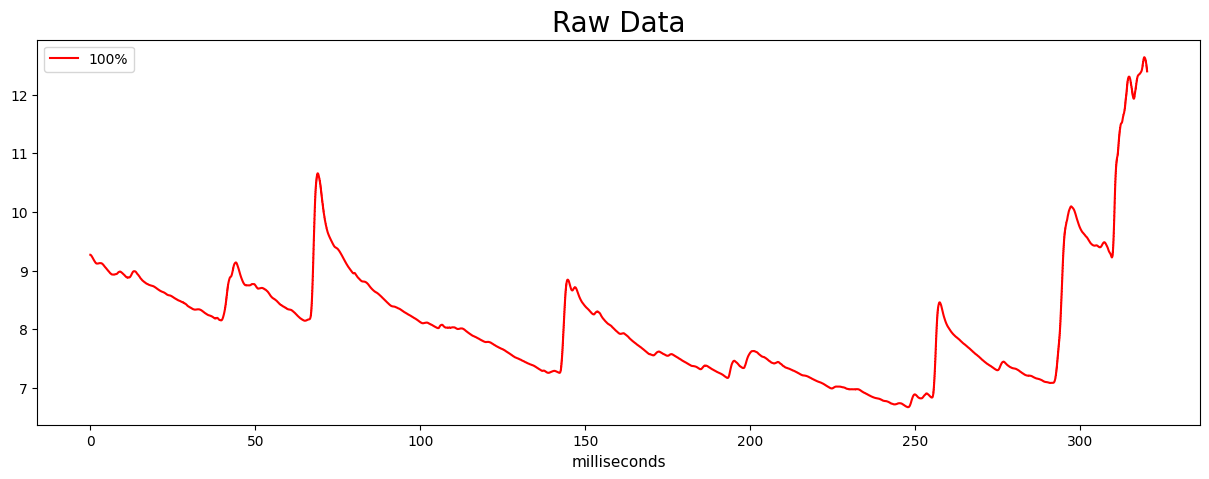

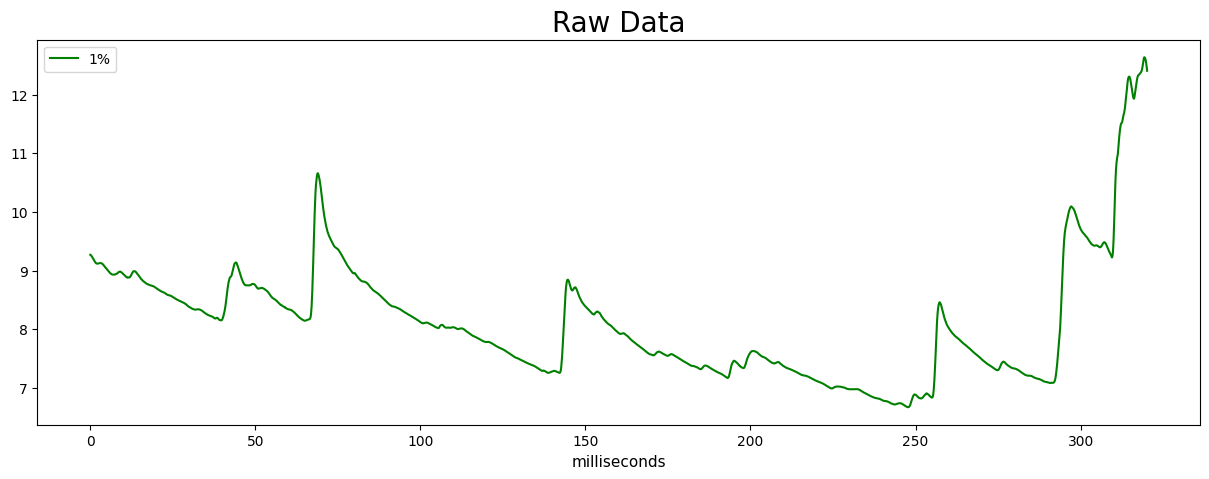

In [114]:
# COMPARACION DEL 100% VS EL 1%
# me falta t1 y v1
# n_vtime,n_vector1

fig,F = plt.subplots(1,1,figsize=(15,5))
F.plot(t2,v2,color = 'red', label='100%')
F.set_title('Raw Data',fontsize=20)
plt.xlabel('milliseconds',fontsize=11)
plt.legend()

fig,G = plt.subplots(1,1,figsize=(15,5))
G.plot(n_vtime2,n_vector2,color = 'green', label='1%')
G.set_title('Raw Data',fontsize=20)
plt.xlabel('milliseconds',fontsize=11)
plt.legend()

plt.show()


In [117]:
# NORMALIZACION DEL VECTOR del 100%
import scipy 
from scipy import stats
y2 = stats.zscore(v2) # y ya está normalizado
Fs = 25;
print(y2)

[1.08962421 1.08962421 1.08962421 ... 4.05980351 4.05980351 4.05980351]


In [124]:
# NORMALIZACION DEL VECTOR del 100%
tm2_100 =[]
for i in range(len(t2)):
    tm2_100.append(t2[i]/Fs)
        
print(tm2_100)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Como no corre con el100% delos datos provemos con el 1% (al igual que el caso anterior)

In [125]:
# NORMALIZACION DEL VECTOR del 1%
import scipy 
from scipy import stats
y2 = stats.zscore(n_vector2) # y ya está normalizado
Fs = 25;
print(y2)

[1.08937851 1.08842845 1.08652835 ... 4.11529663 4.09154531 4.06874405]


In [129]:
n_zscore2 = stats.zscore(n_vector2)
print(n_zscore2)

[1.08937851 1.08842845 1.08652835 ... 4.11529663 4.09154531 4.06874405]


In [126]:
# NORMALIZACION DEL VECTOR del 100%
tm2 =[]
for i in range(len(n_vtime2)):
    tm2.append(n_vtime2[i]/Fs)
        
print(tm2)

[1.953125e-05, 0.00197265625, 0.00392578125, 0.00587890625, 0.00783203125, 0.00978515625, 0.01173828125, 0.01369140625, 0.01564453125, 0.01759765625, 0.01955078125, 0.02150390625, 0.02345703125, 0.02541015625, 0.02736328125, 0.02931640625, 0.03126953125, 0.03322265625, 0.03517578125, 0.03712890625, 0.03908203125, 0.04103515625, 0.04298828125, 0.04494140625, 0.04689453125, 0.04884765625, 0.05080078125, 0.05275390625, 0.05470703125, 0.05666015625, 0.05861328125, 0.06056640625, 0.06251953125, 0.06447265625, 0.06642578125, 0.06837890625, 0.07033203125, 0.07228515625, 0.07423828125, 0.07619140625, 0.07814453125, 0.08009765625, 0.08205078125, 0.08400390625, 0.08595703125, 0.08791015625, 0.08986328125, 0.09181640625, 0.09376953125, 0.09572265625, 0.09767578125, 0.09962890625, 0.10158203125, 0.10353515625, 0.10548828125, 0.10744140625, 0.10939453125, 0.11134765625, 0.11330078125, 0.11525390625, 0.11720703125, 0.11916015625, 0.12111328125, 0.12306640625, 0.12501953125, 0.12697265625, 0.12892578

     pcost       dcost       gap    pres   dres
 0: -3.1683e+03 -3.0456e+03  2e+04  1e+02  6e+00
 1: -3.2332e+03 -5.5974e+03  3e+03  2e+01  1e+00
 2: -3.2634e+03 -3.6982e+03  4e+02  2e+00  1e-01
 3: -3.2678e+03 -3.3611e+03  9e+01  4e-01  2e-02
 4: -3.2695e+03 -3.2859e+03  2e+01  5e-02  2e-03
 5: -3.2750e+03 -3.2780e+03  3e+00  5e-04  2e-05
 6: -3.2768e+03 -3.2777e+03  9e-01  1e-04  5e-06
 7: -3.2772e+03 -3.2775e+03  3e-01  1e-05  7e-07
 8: -3.2773e+03 -3.2774e+03  9e-02  3e-06  2e-07
 9: -3.2773e+03 -3.2773e+03  3e-02  4e-07  2e-08
10: -3.2773e+03 -3.2773e+03  2e-02  3e-07  1e-08
11: -3.2773e+03 -3.2773e+03  7e-03  6e-08  3e-09
12: -3.2773e+03 -3.2773e+03  2e-03  1e-08  5e-10
13: -3.2773e+03 -3.2773e+03  5e-04  7e-10  3e-11
14: -3.2773e+03 -3.2773e+03  4e-04  4e-10  2e-11
15: -3.2773e+03 -3.2773e+03  1e-04  9e-11  5e-12
16: -3.2773e+03 -3.2773e+03  7e-05  4e-11  2e-12
17: -3.2773e+03 -3.2773e+03  2e-05  1e-11  9e-13
18: -3.2773e+03 -3.2773e+03  1e-05  8e-12  6e-13
19: -3.2773e+03 -3.27

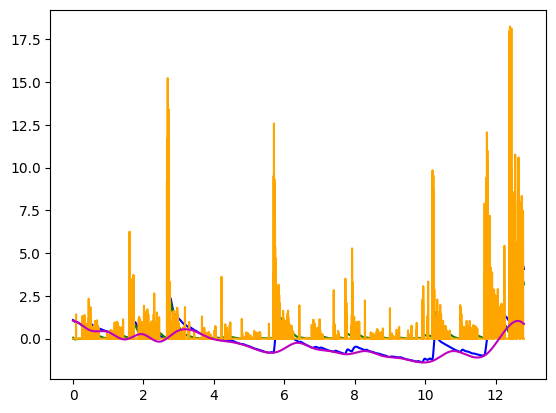

In [130]:
# falta general a tm

# con el 100% de los datos no funciona bien
#yn = (y - y.mean()) / y.std()
Fs = 25.
[r, p, t, l, d, e, obj] = cvxEDA(y2, 1./Fs) # cvxEDA(yn, 1./Fs)

import pylab as pl
#pl.hold(True)
pl.plot(tm2, n_zscore2, color= 'blue')
pl.plot(tm2, r, color= 'green')
pl.plot(tm2, p, color= 'orange')
pl.plot(tm2, t, color= 'm')
pl.show()


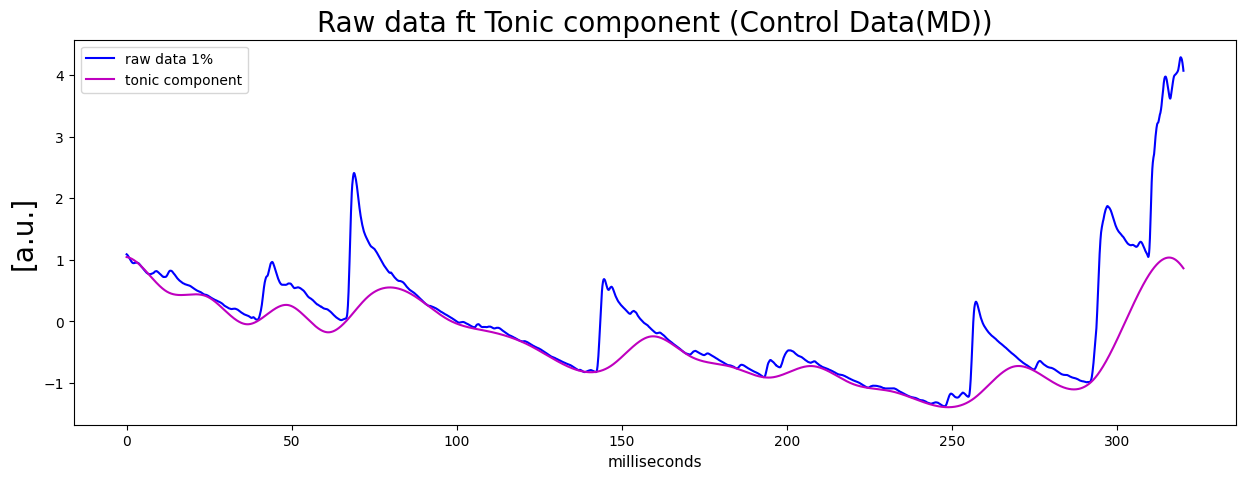

In [132]:
plt.figure(figsize=(15,5))
#plt.xlim(500,650000)
#plt.ylim(15,50)
plt.plot(n_vtime2,n_zscore2,color = 'blue', label='raw data 1%')
plt.plot(n_vtime2,t,color = 'm', label='tonic component')
plt.ylabel('[a.u.]',fontsize=20) #unidad adimensional normalizada de los datos del programa
plt.xlabel('milliseconds',fontsize=11)
plt.title('Raw data ft Tonic component (Control Data(MD))',fontsize=20)
plt.legend()
plt.show()

## Cálculo del index

In [134]:
df_datos2['B: BVP'].min()

0.0

In [140]:
# GENERACION DE UN VECTOR CON EL 1% DE LOS DATOS PARA EL RITMO  CARDIACO

b2 = []

for i in range (0,655744,100):
    x = df_datos2.iloc[i,1]
    b2.append(x)
print(b2)

[0.0, 22.568, 41.331, 37.395, 38.925, 38.155, 37.847, 37.485, 37.483, 37.567, 37.44, 37.355, 37.356, 37.278, 37.196, 37.091, 37.361, 37.827, 37.63, 37.268, 36.895, 36.798, 36.982, 37.079, 36.955, 36.96, 36.974, 36.952, 37.08, 37.781, 38.218, 37.918, 37.556, 37.291, 37.408, 37.663, 37.712, 37.702, 37.657, 37.579, 37.495, 37.753, 38.47, 38.509, 38.138, 37.759, 37.547, 37.672, 37.798, 37.805, 37.742, 37.687, 37.608, 37.545, 37.939, 38.685, 38.624, 38.249, 37.85, 37.698, 37.823, 37.931, 37.903, 37.853, 37.779, 37.708, 37.622, 37.597, 38.101, 38.798, 38.59, 38.234, 37.893, 37.722, 37.857, 37.854, 37.718, 37.586, 37.448, 37.343, 37.218, 37.132, 37.099, 37.706, 38.212, 37.896, 37.611, 37.309, 37.197, 37.31, 37.298, 37.146, 37.011, 36.852, 36.726, 36.656, 36.605, 36.57, 37.014, 37.847, 37.95, 37.78, 37.599, 37.546, 37.757, 37.986, 38.046, 38.091, 38.085, 38.047, 38.056, 38.001, 37.937, 38.248, 39.065, 39.187, 38.82, 38.344, 37.948, 37.917, 38.004, 37.978, 37.987, 38.038, 38.092, 38.126, 38.299

In [141]:
len(b2)

6558

In [147]:
# NORMALIZACION DEL VECTOR
#import scipy 
#from scipy import stats
bzscore2 = stats.zscore(b2)
# y ya está normalizado
Fs = 25;
print(bzscore2)

[-19.70617447  -7.85873574   1.99120634 ...  -0.31549544  -0.13385711
   0.11760173]


In [148]:
# ESTE VECTOR ES GSR_z
print(len(t))
print('GSR_z: ',t,)

6558
GSR_z:  [1.04470993 1.04432494 1.04390448 ... 0.86963766 0.86599393 0.86231958]


In [149]:
# ESTE VECTOR ES HR_z
print(len(bzscore2))
print('HR_z: ',bzscore2,)

6558
HR_z:  [-19.70617447  -7.85873574   1.99120634 ...  -0.31549544  -0.13385711
   0.11760173]


In [150]:
# GENERACION DE UN VECTOR theta
theta2 = []
for i in range (0,6558):
    r = t[i]/bzscore2[i]   # t = GSR_z   &  HR_z = b
    x = math.atan(r) #resultado en radianes
    theta2.append(x)
#print(theta)

# GENERACION DE UN VECTOR EMOTIONAL INDEX
beta2 = np.zeros (6558)
EI2 = np.zeros (6558)
for i in range (0,6558):
    if t[i] >= 0 and bzscore2[i] <= 0:
        beta2[i] = (2/3)*math.pi + math.pi - theta2[i]
    else:
        beta2[i] = math.pi/2 - theta2[i]

    EI2[i] = 1- beta2[i]/math.pi

print(EI2)


[-0.68352587 -0.70871958  0.65370058 ... -1.05588755 -1.11785167
  0.95685559]


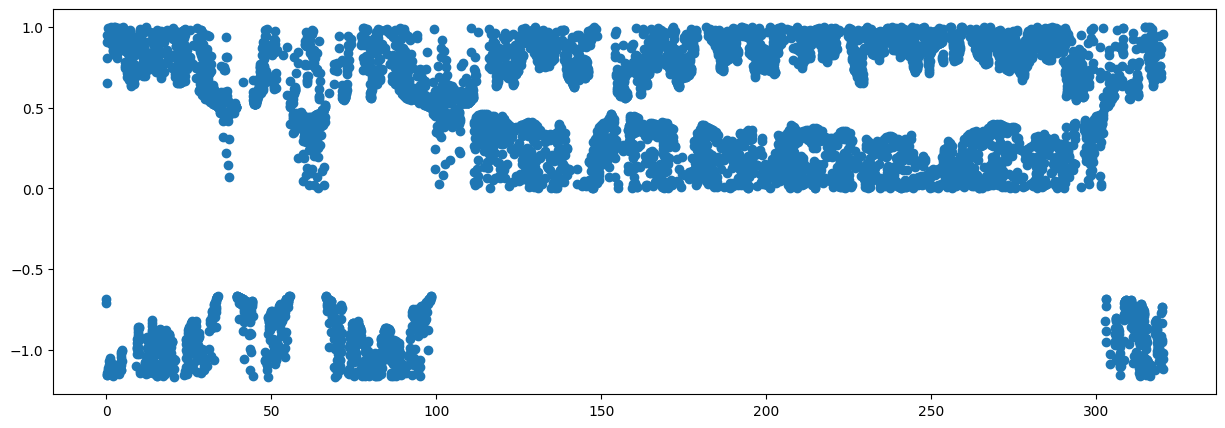

In [151]:
plt.figure(figsize=(15,5))
#plt.plot(n_vtime,EI,color = 'blue', label='Emotional index')
plt.scatter(n_vtime2,EI2) #,label='Emotional index')
#plt.ylabel('',fontsize=20) #unidad adimensional normalizada de los datos del programa
#plt.xlabel('',fontsize=11)
#plt.title('Emotional index over time in the control test (MD data)',fontsize=20)
#plt.legend()
plt.show()

### BIBLIOGRAFÍA

### cvx EDA

https://github.com/lciti/cvxEDA

### spMatrix: Sparse Matrix Constructor From Triplet

### numpy.tile(arr, repetitions)

The numpy.tile() function constructs a new array by repeating array – ‘arr’, the number of times we want to repeat as per repetitions.

### np.convolve
The convolution operator is often seen in signal processing, where it models the effect of a linear time-invariant system on a signal. In probability theory, the sum of two independent random variables is distributed according to the convolution of their individual distributions.

https://numpy.org/doc/stable/reference/generated/numpy.convolve.html

### np.c  / np.r
The strings ‘r’ or ‘c’ result in matrix output. If the result is 1-D and ‘r’ is specified a 1 x N (row) matrix is produced. If the result is 1-D and ‘c’ is specified, then a N x 1 (column) matrix is produced. If the result is 2-D then both provide the same matrix result.

###  cv.solvers.options.


### cv.sparse

###  cv.solvers.conelp

### numpy.ravel(a, order='C')

Return a contiguous flattened array.



https://cvxopt.org/

https://programmerclick.com/article/5617538313/#:~:text=La%20normalizaci%C3%B3n%20generalmente%20asigna%20los%20datos%20a%20%5B0%2C1%5D%2C,MaxAbsScaler%20en%20Python%2C%20respectivamente.%20MinMaxScaler%3A%20normalizado%20a%20%5B0%2C1%5D

https://datagy.io/python-z-score/ 

https://docs.scipy.org/doc/scipy/tutorial/stats.html

https://numpy.org/doc/stable/reference/generated/numpy.ravel.html